In [1]:
import visualize.utils
from models import ConvAttnNet
from models import resnet
from models import convnext
import models
# import networks
from visualize.grad_cam import GradCAM
import visualize.utils as utils
from visualize.plot_utils import plot_confmat, plot_gradcam

import torch
import cv2
import pandas as pd
import numpy as np
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Datasets.datasets import MyDataset
import matplotlib.pyplot as plt
import copy

In [2]:
def show(x):
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
def read_img(path):
    file = cv2.imread(path)
    file = cv2.cvtColor(file,cv2.COLOR_BGR2RGB)
    file = file/255.
    file = file.astype('float32')
    return file

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dirs_train = 'E:/datasets/project1/4s/Voxceleb/spec/sample/'
train_set = datasets.ImageFolder(root=dirs_train, transform=utils.transform['eval'])

### Build Model

In [4]:
convattnnet = ConvAttnNet.dnn_34(num_classes=1).cuda()
resnet = resnet.dnn_50(num_classes=1).cuda()
convnext = convnext.convnext_small(num=1).cuda()
models.load_snapshot(ConvAttnNet, 'ENF', '20220408_100718', 3)
models.load_snapshot(resnet, 'ENF', '20220408_102150', 3)
models.load_snapshot(convnext, 'ENF', '20220406_205617', 3)

D:\anaconda\envs\pytorch19\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Caculate Heat map

In [5]:
def get_heat(model, dataset, sample_num):
    img, label = dataset[sample_num]
    img = img.unsqueeze(dim=0).to(device)
    preds, heat = model(img)
    heat = heat.detach().cpu().numpy()
    return preds, heat.squeeze(axis=0)

def get_weights_list(model):
    parm={}
    for name,parameters in model.named_parameters():
        # print(name,':',parameters.size())
        parm[name]=parameters.detach().cpu().numpy()
    
    return parm

def get_cam(heat, cam_shape=(224,224)):
    cam = np.maximum(heat, 0)
    cam = cv2.resize(cam, cam_shape)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

In [6]:
preds, h = get_heat(convnext, train_set, 2)
preds2, h2 = get_heat(resnet, train_set, 2)
preds3, h3 = get_heat(alternet, train_set, 2)

parm = get_weights_list(convnext)
parm2 = get_weights_list(resnet)
parm3 = get_weights_list(alternet)

weight_convnext0 = parm['head.weight']
weight_res1 = parm2['classifier.0.dense.weight']
weight_alter1 = parm3['classifier.0.dense.weight']

heat = np.mean(np.einsum('ni, ijk->ijk', weight_convnext0, h), axis=0)
heat2 = np.mean(np.einsum('ni, ijk->ijk', weight_res1, h2), axis=0)
heat3 = np.mean(np.einsum('ni, ijk->ijk', weight_alter1, h3), axis=0)

cam = get_cam(heat)
cam2 = get_cam(heat2)
cam3 = get_cam(heat3)

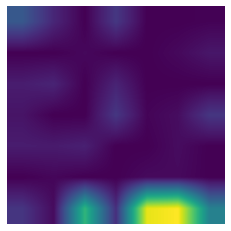

In [9]:
show(cam)

In [ ]:
org_img = read_img('E:/datasets/project1/2s/spec/0dB_224/0dB_03_04_461.jpeg')
gard_cam = plot_gradcam(org_img, cam, cam2, cam3)